1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd

N = 1000000
filepath = './data/data_000637.txt'

df = pd.read_csv(filepath, sep=',', header=0, nrows=N)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
999995,1,0,62,3869209011,2560,29
999996,1,0,51,3869209011,2561,12
999997,1,0,61,3869209011,2562,2
999998,1,0,50,3869209011,2563,4


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
max_bx_counter = df['BX_COUNTER'].max()
reset_rows = df[df['BX_COUNTER'] < df['BX_COUNTER'].shift(1)]
reset_diff = reset_rows['BX_COUNTER'].diff().max()
x = reset_diff
print("The estimated value of x (number of BX in an ORBIT) is:", x)

The estimated value of x (number of BX in an ORBIT) is: 3561.0


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [4]:
tdc_ns = 25 / 30
bx_ns = 25       

# Calculate absolute time in ns
df['absolute_time_ns'] = (
    (df['ORBIT_CNT'] * 25 * x + df['BX_COUNTER']) * bx_ns +
    df['TDC_MEAS'] * tdc_ns
)

start_time = df['absolute_time_ns'].min()
df['absolute_time_ns'] -= start_time

# Convert the new column to a Time Series
df['absolute_time'] = pd.to_datetime(df['absolute_time_ns'], unit='ns')

print(df[['ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS', 'absolute_time_ns', 'absolute_time']])

         ORBIT_CNT  BX_COUNTER  TDC_MEAS  absolute_time_ns  \
0       3869200167        2374        26      0.000000e+00   
1       3869200167        2374        27      1.000000e+00   
2       3869200167        2553        28      4.476000e+03   
3       3869200167        2558        19      4.594000e+03   
4       3869200167        2760        25      9.649000e+03   
...            ...         ...       ...               ...   
999995  3869209011        2560        29      1.968343e+10   
999996  3869209011        2561        12      1.968343e+10   
999997  3869209011        2562         2      1.968343e+10   
999998  3869209011        2563         4      1.968343e+10   
999999  3869209011        2688        25      1.968344e+10   

                       absolute_time  
0      1970-01-01 00:00:00.000000000  
1      1970-01-01 00:00:00.000000001  
2      1970-01-01 00:00:00.000004476  
3      1970-01-01 00:00:00.000004594  
4      1970-01-01 00:00:00.000009649  
...                  

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
start_time = df['absolute_time'].min()
end_time = df['absolute_time'].max()

duration = end_time - start_time

hours, remainder = divmod(duration.total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)

print(f"Duration: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

Duration: 0 hours, 0 minutes, 19 seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
channel_counts = df.groupby('TDC_CHANNEL').size().reset_index(name='count')
channel_counts = channel_counts.sort_values(by='count', ascending=False)

top_noisy_channels = channel_counts.head(3)
print("Top 3 Noisy Channels:")
print(top_noisy_channels)

Top 3 Noisy Channels:
     TDC_CHANNEL  count
132          139  82677
63            64  50201
62            63  49335


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
non_empty_orbits = df[df['HEAD'] == 1]
num_non_empty_orbits = non_empty_orbits['ORBIT_CNT'].nunique()

print("Number of Non-Empty Orbits:", num_non_empty_orbits)

Number of Non-Empty Orbits: 8841


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
tdc_139_rows = df[(df['TDC_CHANNEL'] == 139) & (df['HEAD'] == 1)]
num_unique_orbits_tdc_139 = tdc_139_rows['ORBIT_CNT'].nunique()

print("Number of Unique Orbits with TDC_CHANNEL=139:", num_unique_orbits_tdc_139)

Number of Unique Orbits with TDC_CHANNEL=139: 8816


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [9]:
channel_counts_by_fpga = df.groupby(['FPGA', 'TDC_CHANNEL']).size().reset_index(name='count')

fpga1_series = channel_counts_by_fpga[channel_counts_by_fpga['FPGA'] == 0].set_index('TDC_CHANNEL')['count']
fpga2_series = channel_counts_by_fpga[channel_counts_by_fpga['FPGA'] == 1].set_index('TDC_CHANNEL')['count']

print("FPGA 1 Series:")
print(fpga1_series.head())

print("\nFPGA 2 Series:")
print(fpga2_series.head())

FPGA 1 Series:
TDC_CHANNEL
1     933
2    1207
3    1156
4    1794
5    1096
Name: count, dtype: int64

FPGA 2 Series:
TDC_CHANNEL
1    21622
2    24871
3    16725
4    20087
5    11375
Name: count, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

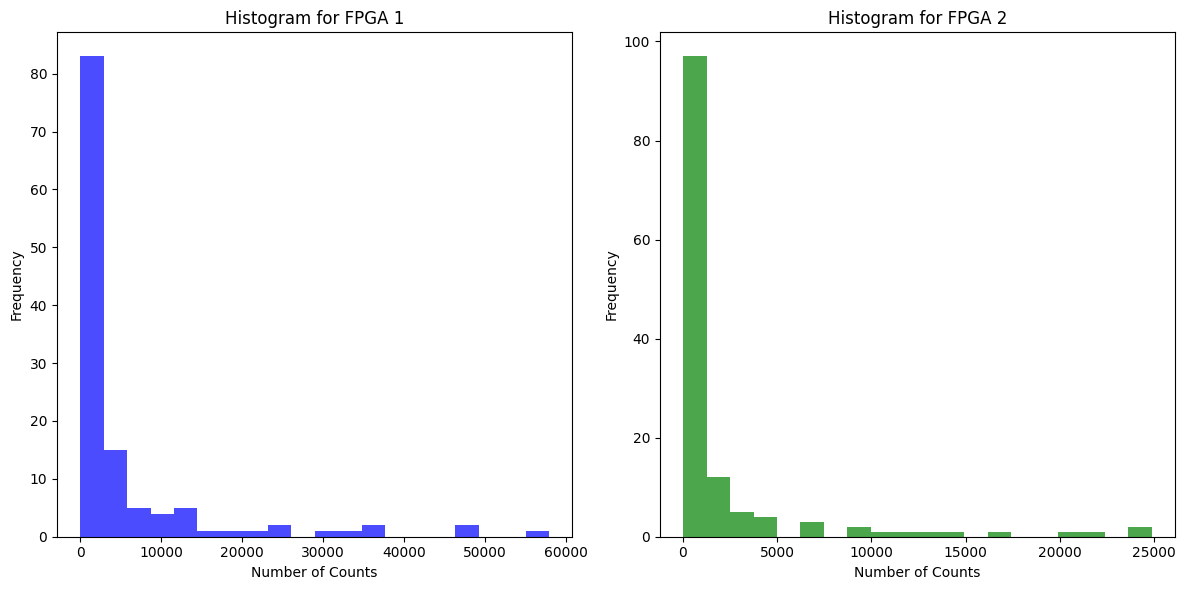

In [10]:
import matplotlib.pyplot as plt

# Group by 'FPGA' and 'TDC_CHANNEL' and count occurrences
channel_counts_by_fpga = df.groupby(['FPGA', 'TDC_CHANNEL']).size().reset_index(name='count')

# Separate the counts for each FPGA into two Series
fpga1_series = channel_counts_by_fpga[channel_counts_by_fpga['FPGA'] == 0].set_index('TDC_CHANNEL')['count']
fpga2_series = channel_counts_by_fpga[channel_counts_by_fpga['FPGA'] == 1].set_index('TDC_CHANNEL')['count']

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fpga1_series, bins=20, color='blue', alpha=0.7)
plt.title('Histogram for FPGA 1')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(fpga2_series, bins=20, color='green', alpha=0.7)
plt.title('Histogram for FPGA 2')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()